# Classification with Python

The goal is to classify and predict which basketball teams are most likely to make it to the semifinals of a College Basketball (NCCA) Tournament.

Dataset has data on the performance of these college basketball teams. This data from five seasons of 354 basketball teams.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


### Load Data From CSV File


Load the dataset:


In [2]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/cbb.csv')
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


In [3]:
df.shape

(1406, 24)

## Add Column

Lets add a column that will contain "true" if the wins above bubble (one of the last few positions on the roster) are over 7 and "false" if not. This column is called win index ("windex"). 


In [4]:
df['windex'] = np.where(df.WAB > 7, 'True', 'False')

# Data visualization and pre-processing


Now lets filter the data set to the teams that made it to the Round of 16 (Sweet Sixteen), the quarterfinals (Elite Eight), and the semifinals (Final Four) in the post season. 

Also It is created a new dataframe that will hold the values of this the new column.


In [5]:
df1 = df.loc[df['POSTSEASON'].str.contains('F4|S16|E8', na=False)]
df1.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,False
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,True
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,True
5,Oregon,P12,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,...,52.6,46.1,34.4,36.2,69.0,6.7,E8,1.0,2016,False
6,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016,False


In [6]:
df1['POSTSEASON'].value_counts()

S16    32
E8     16
F4      8
Name: POSTSEASON, dtype: int64

32 teams made it into Sweet Sixteen, 16 teams into the Elite Eight, and 8 made it into the Final Four over 5 seasons. 


"*BARTHAG*" is a term given to the estimate of what a team's chance of winning would be against the average NCCA Division 1 team. 

With this in mind, lets try to understand the data:

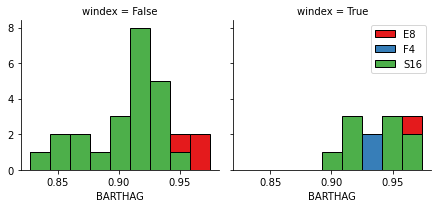

In [7]:
import seaborn as sns

bins = np.linspace(df1.BARTHAG.min(), df1.BARTHAG.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=6)
g.map(plt.hist, 'BARTHAG', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

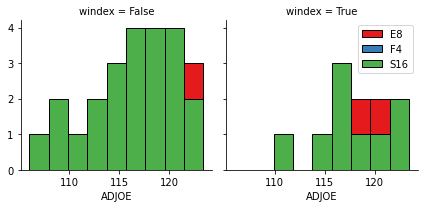

In [8]:
bins = np.linspace(df1.ADJOE.min(), df1.ADJOE.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ADJOE', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


How Adjusted Defense Efficiency ("ADJDE") plots:


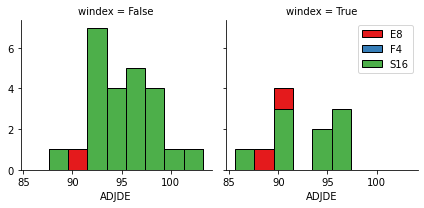

In [9]:
bins = np.linspace(df1.ADJDE.min(), df1.ADJDE.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ADJDE', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that this data point doesn't impact the ability of a team to get into the Final Four. 


## Convert Categorical features to numerical values


Looking at the postseason:


In [10]:
df1.groupby(['windex'])['POSTSEASON'].value_counts(normalize=True)

windex  POSTSEASON
False   S16           0.605263
        E8            0.263158
        F4            0.131579
True    S16           0.500000
        E8            0.333333
        F4            0.166667
Name: POSTSEASON, dtype: float64

13% of teams with 6 or less wins above bubble make it into the final four while 17% of teams with 7 or more do.


Lets convert wins above bubble ("winindex") under 7 to 0 and over 7 to 1:


In [11]:
df1['windex'].replace(to_replace=['False','True'], value=[0,1],inplace=True)
df1.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,0
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,1
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,1
5,Oregon,P12,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,...,52.6,46.1,34.4,36.2,69.0,6.7,E8,1.0,2016,0
6,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016,0


### Feature selection


Defining feature set:


In [12]:
X = df1[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'SEED', 'windex']]
X[0:5]

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,windex
2,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,14.8,32.7,...,32.9,26.0,52.9,46.5,37.4,36.9,65.5,2.3,6.0,0
3,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,18.8,29.9,...,32.1,33.4,52.6,46.3,40.3,34.7,61.9,8.6,1.0,1
4,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,18.5,32.2,...,38.6,37.3,52.7,43.4,41.3,32.5,70.1,11.6,1.0,1
5,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,20.2,34.1,...,40.3,32.0,52.6,46.1,34.4,36.2,69.0,6.7,1.0,0
6,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,20.4,33.5,...,35.4,28.0,47.2,48.1,36.0,30.7,65.5,-0.3,10.0,0


Lable description: (R68 = Initial four, R64 = Round of 64, R32 = Round of 32, S16 = Round of 16, E8 = Quarterfinals, F4 = Semifinals, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

In [13]:
y = df1['POSTSEASON'].values
y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance:


In [14]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.43331874, -1.26140173,  0.28034482,  2.74329908, -2.45717765,
         0.10027963,  0.94171924, -1.16188145, -1.71391372,  0.12750511,
         1.33368704, -0.4942211 , -0.87998988,  0.02784185,  0.00307239,
         0.22576157,  1.59744386, -1.12106011, -1.0448016 ,  0.49716104,
        -0.6882472 ],
       [ 0.40343468,  0.35874728,  0.64758014, -0.90102957,  1.127076  ,
         0.39390887,  0.38123706, -1.29466791, -0.03522254, -0.62979797,
        -1.31585883, -0.68542235,  0.55458056, -0.07167795, -0.0829545 ,
         1.32677295,  0.65081046, -2.369021  ,  0.98050611, -1.14054592,
         1.45296631],
       [ 0.40343468,  1.33083669,  0.87710222, -1.0788017 ,  1.29403598,
         0.72424177, -1.30020946,  0.49794919, -0.16112438, -0.00772758,
        -0.27908001,  0.86808783,  1.31063795, -0.03850468, -1.33034432,
         1.70643205, -0.29582294,  0.47355659,  1.94493836, -1.14054592,
         1.45296631],
       [ 0.40343468,  0.68277708,  0.30329703,  0.63966222

## Training and Validation


Splitting the data into Training and Validation data:


In [15]:
from sklearn.model_selection import train_test_split


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)


Train set: (44, 21) (44,)
Validation set: (12, 21) (12,)


# Classification


Used algorithms:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression


In [17]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


# K Nearest Neighbor(KNN)

In [18]:
from sklearn.neighbors import KNeighborsClassifier as knn


Accuracy for the first 15 values of k the on the validation data:


Text(0, 0.5, 'Testing Accuracy Values')

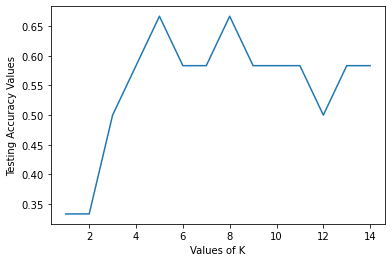

In [19]:
ks = range(1, 15)
mean_accuracy = []

for n in ks:
    knn_model  = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_val)
    mean_accuracy.append(accuracy_score(y_val, knn_yhat))
    
plt.plot(ks, mean_accuracy)
plt.xlabel('Values of K')
plt.ylabel('Testing Accuracy Values')

#chose model with k=5

# Decision Tree


In [20]:
from sklearn.tree import DecisionTreeClassifier


Minumum value for the parameter *'max_depth'* that improves results:


In [21]:
depth_range = range(1, 10)

for d in depth_range:
    dt = DecisionTreeClassifier(criterion="entropy", max_depth = d)
    dt.fit(X_train, y_train)
    dt_yhat = dt.predict(X_val)
    print("DecisionTrees's Accuracy: ", accuracy_score(y_val, dt_yhat))  

#chose model with max_depth=2

DecisionTrees's Accuracy:  0.6666666666666666
DecisionTrees's Accuracy:  0.6666666666666666
DecisionTrees's Accuracy:  0.5
DecisionTrees's Accuracy:  0.3333333333333333
DecisionTrees's Accuracy:  0.4166666666666667
DecisionTrees's Accuracy:  0.5
DecisionTrees's Accuracy:  0.5
DecisionTrees's Accuracy:  0.5
DecisionTrees's Accuracy:  0.5


# Support Vector Machine


In [22]:
from sklearn import svm


For *'c=0.01'*, best accuracy score for diferent kernel functions:

Accuracy scores: [0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333]


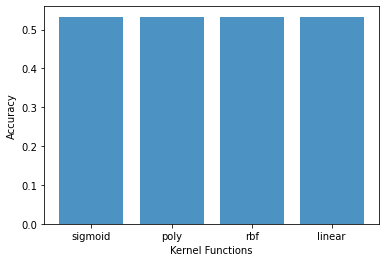

In [23]:
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
accuracy_scores = []

for k in kernel_func:
    svc_model = svm.SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(X_train, y_train)
    svc_yhat = svc_model.predict(X_val)
    accuracy_scores.append(f1_score(y_val, svc_yhat, average = 'weighted'))
    
y_pos = np.arange(len(kernel_func))
plt.bar(y_pos, accuracy_scores, align='center', alpha = 0.8)
plt.xticks(y_pos, kernel_func)
plt.xlabel('Kernel Functions')
plt.ylabel('Accuracy')
print('Accuracy scores:',accuracy_scores)

#chose any of the kernel functions

# Logistic Regression


For *'c=0.01'*, accuracy of the validation data:


In [24]:
from sklearn.linear_model import LogisticRegression


In [25]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_val)
yhat_prob = LR.predict_proba(X_val)
print ("LogLoss: : %.2f" % log_loss(y_val, yhat_prob))


LogLoss: : 1.10


# Model Evaluation using Test set


Calculating the  F1 score and Jaccard Similarity score for each model from above:


### Load Test set for evaluation


In [26]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/basketball_train.csv',error_bad_lines=False)
test_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


In [27]:
test_df['windex'] = np.where(test_df.WAB > 7, 'True', 'False')
test_df1 = test_df[test_df['POSTSEASON'].str.contains('F4|S16|E8', na=False)]
test_Feature = test_df1[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'SEED', 'windex']]
test_Feature['windex'].replace(to_replace=['False','True'], value=[0,1],inplace=True)
test_X=test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[-4.08074446e-01, -1.10135297e+00,  3.37365934e-01,
         2.66479976e+00, -2.46831661e+00,  2.13703245e-01,
         9.44090550e-01, -1.19216365e+00, -1.64348924e+00,
         1.45405982e-02,  1.29523097e+00, -6.23533182e-01,
        -9.31788560e-01,  1.42784371e-01,  1.68876201e-01,
         2.84500844e-01,  1.62625961e+00, -8.36649260e-01,
        -9.98500539e-01,  4.84319174e-01, -6.77003200e-01],
       [ 3.63958290e-01,  3.26326807e-01,  7.03145068e-01,
        -7.13778644e-01,  1.07370841e+00,  4.82633172e-01,
         4.77498943e-01, -1.32975879e+00, -6.86193316e-02,
        -7.35448152e-01, -1.35447914e+00, -8.06829025e-01,
         3.41737757e-01,  4.96641291e-02,  9.40576311e-02,
         1.37214061e+00,  6.93854620e-01, -2.00860931e+00,
         9.80549967e-01, -1.19401460e+00,  1.47709789e+00],
       [ 3.63958290e-01,  1.18293467e+00,  9.31757027e-01,
        -8.78587347e-01,  1.23870131e+00,  7.85179340e-01,
        -9.22275877e-01,  5.27775662e-01, -1.86734575e

In [28]:
test_y = test_df1['POSTSEASON'].values
test_y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)

KNN


In [29]:
knn_model = knn(n_neighbors = 5)
knn_model.fit(X_train, y_train)

knn_yhat = knn_model.predict(test_X)

accuracy1 = accuracy_score(test_y, knn_yhat)
f1 = round(f1_score(test_y, knn_yhat, average = 'micro'), 6)
jc1 = round(jaccard_score(test_y, knn_yhat, average = 'micro'), 6)
print("Accuracy: : %.6f" % accuracy1)
print("F1 score: : %.6f" % f1)
print("Jaccard score: : %.6f" % jc1)


Accuracy: : 0.628571
F1 score: : 0.628571
Jaccard score: : 0.458333


Decision Tree


In [30]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
dt_model.fit(X_train, y_train)

dt_yhat = dt_model.predict(test_X)

accuracy2 = accuracy_score(test_y, dt_yhat)
f2 = round(f1_score(test_y, dt_yhat, average = 'micro'), 6)
jc2 = round(jaccard_score(test_y, dt_yhat, average = 'micro'), 6)
print("Accuracy: : %.6f" % accuracy2)
print("F1 score: : %.6f" % f2)
print("Jaccard score: : %.6f" % jc2)

Accuracy: : 0.657143
F1 score: : 0.657143
Jaccard score: : 0.489362


SVM


In [31]:
svc_model = svm.SVC(C = 0.01, gamma = 'auto', kernel = 'poly')
svc_model.fit(X_train, y_train)

svc_yhat = svc_model.predict(test_X)

accuracy3 = accuracy_score(test_y, svc_yhat)
f3 = round(f1_score(test_y, svc_yhat, average = 'micro'), 6)
jc3 = round(jaccard_score(test_y, svc_yhat, average = 'micro'), 6)
print("Accuracy: : %.6f" % accuracy3)
print("F1 score: : %.6f" % f3)
print("Jaccard score: : %.6f" % jc3)

Accuracy: : 0.571429
F1 score: : 0.571429
Jaccard score: : 0.400000


Logistic Regression


In [32]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_test = LR.predict(test_X)
yhat_prob_test = LR.predict_proba(test_X)

ll4 = log_loss(test_y, yhat_prob_test)
accuracy4 = accuracy_score(test_y, yhat_test)
f4 = round(f1_score(test_y, yhat_test, average = 'micro'), 6)
jc4 = round(jaccard_score(test_y, yhat_test, average = 'micro'), 6)

print("Accuracy: : %.6f" % accuracy3)
print("F1 score: : %.6f" % f4)
print("Jaccard score: : %.6f" % jc4)
print ("LogLoss: : %.2f" % ll4)

#final evaluation list
accuracy_list = [accuracy1, accuracy2, accuracy3, accuracy4]
f1_list = [f1, f2, f3, f4]
jc_list = [jc1, jc2, jc3, jc4]
ll_list = ['NA','NA','NA', ll4]

#showing data on a table
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Accuracy', 'F1-score', 'Jaccard score', 'Logloss']

accuracy_df = pd.DataFrame([accuracy_list, f1_list, jc_list, ll_list], index = index, columns = columns)

accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Accuracy: : 0.571429
F1 score: : 0.685714
Jaccard score: : 0.521739
LogLoss: : 1.04


Algorithm,Accuracy,F1-score,Jaccard score,Logloss
KNN,0.628571,0.628571,0.458333,NA
Decision Tree,0.657143,0.657143,0.489362,NA
SVM,0.571429,0.571429,0.4,NA
Logistic Regression,0.685714,0.685714,0.521739,1.037187


# Conclusion

An accuracy of 52.4% or above is considered profitable according to [study](https://journals.sagepub.com/doi/abs/10.1177/1527002504266861?casa_token=Ok4XrRjgy3UAAAAA:Kyq2jQzNgVXpjIdKThoizt-LWFArdib4f69BotUv3BT1fUJe--yB_cinLG5EfZnBKtg5e-geJEvq) on NBA focusing on the seasons from 1995 to 2001. Thus, above 57% can be consider as a good accuracy or being profitable, even with a conservative look, because 4.6% above break-even is acting as a buffer. 

Concluding, profitability is expected if the built models are used.  

Lastly, classification models accuracy are as following:

| Algorithm           | Accuracy | F1-score | Jaccard  | LogLoss |
| ------------------  | -------- | -------- | -------- | ------- |
| KNN                 | 0.628571 | 0.628571 | 0.458333 | NA      |
| Decision Tree       | 0.657143 | 0.657143 | 0.489362 | NA      |
| SVM                 | 0.571429 | 0.571429 | 0.400000 | NA      |
| Logistic Regression | 0.685714 | 0.685714 | 0.521739 | 1.03719 |
